In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### SVM - Multi-Class Classifier


The function below takes in a test DF, features (which we can modified in the event we have thousands of columns and they are named numerically -- in this case we just need to drop the target variable to define X). It runs cross validation to determine the best hyperparameters to be used for the support vector machine model, returning a grid search object with the following attributes (per ChatGPT):

<b>Attributes</b>
* best_estimator_: The estimator that was chosen by the search, i.e., the estimator which gave highest score (or smallest loss if specified) on the left out data. Not available if refit=False.
* best_score_: The score of the best_estimator on the left out data.
* best_params_: The parameter setting that gave the best results on the hold out data.
* best_index_: The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.
* cv_results_: A dictionary with keys as column headers and values as columns, that can be imported into a pandas DataFrame. This attribute provides scores, fit times, score times, and parameters for all the candidate models. It contains a lot of detailed information for each parameter combination that was evaluated.
* scorer_: The function or a dictionary of functions that scores the predictions on the test set.
* n_splits_: The number of cross-validation splits (folds/iterations).
* refit_time_: Time for refitting the best estimator on the whole dataset (available only if refit is set to True).

<b>Methods</b>
* fit(X, y=None, groups=None): Run fit with all sets of parameters.
* predict(X): Call predict on the estimator with the best found parameters.
* score(X, y=None): Returns the score on the given data, if the estimator has been refit.
* predict_proba(X): Call predict_proba on the estimator with the best found parameters, if available.
* decision_function(X): Call decision_function on the estimator with the best found parameters, if available.
* transform(X): Call transform on the estimator with the best found parameters, if available.
* inverse_transform(X): Call inverse_transform on the estimator with the best found parameters, if available.

In [2]:
train_df = pd.read_pickle('/Users/erin/Documents/comp-viz/fabric/pkls/train_0406.pkl')
train_df.head()

,label,category,0,1,2,3,4,5,6,7,...,22,23,24,25,26,27,28,29,30,31
0,0,Blended,3441.793288,2.028531e+07,1844.056770,0.150226,346.120911,0.005210,0.000093,0.000063,...,0.027344,0.054688,0.035156,0.039062,0.031250,0.027344,0.046875,0.062500,0.050781,0.050781
1,1,Denim,7211.992783,7.747671e+06,2271.840993,0.151475,348.998260,0.004833,-0.000067,0.000038,...,0.100000,0.048649,0.021622,0.024324,0.013514,0.021622,0.024324,0.043243,0.016216,0.070270
2,2,Polyester,8856.756862,5.854463e+06,1967.259618,0.160454,369.684998,0.002032,-0.000002,0.000008,...,0.027778,0.004630,0.004630,0.250000,0.129630,0.194444,0.018519,0.004630,0.027778,0.004630
3,0,Blended,7018.112788,7.817569e+06,1953.124972,0.152300,350.899200,0.004582,0.000011,0.000034,...,0.052239,0.063433,0.052239,0.007463,0.022388,0.044776,0.085821,0.074627,0.033582,0.029851
4,3,Cotton,7932.263905,6.971318e+06,2053.412469,0.157971,363.965454,0.002823,-0.000003,0.000017,...,0.030612,0.047619,0.054422,0.047619,0.051020,0.081633,0.013605,0.044218,0.047619,0.054422


In [8]:
def svm_grid_search_cv(X, y, cv_folds=5):
    """
    Perform grid search cross-validation for SVM classifier on the given dataframe.
    
    Parameters:
    # - dataframe: The pandas DataFrame containing the dataset.
    # - features: List of column names to be used as features.
    - target: The name of the column to be used as the target variable.
    - cv_folds: Number of folds for cross-validation.
    
    Returns:
    - grid_search: The fitted GridSearchCV object.
    """
    
    # # Separate the features and the target variable
    # X = dataframe[features]
    # y = dataframe[target]
    
    # Split the data into training and testing sets (optional, could also perform CV on the entire dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
    
    # Define a pipeline that includes scaling and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling is important for SVM
        ('svm', SVC(probability=True))  # SVM classifier
    ])
    
    # Parameter grid for GridSearchCV
    param_grid = {
        'svm__C': [0.1, 1, 10],  # SVM regularization parameter
        'svm__kernel': ['linear', 'rbf'],  # Kernel type to be used in the algorithm
        'svm__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='accuracy', verbose=3, n_jobs=-1)
    
    # Perform grid search cross-validation
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    
    # Optionally, evaluate on the test set
    test_score = grid_search.score(X_test, y_test)
    print("Test set score: {:.2f}".format(test_score))
    
    return grid_search

In [9]:
X = train_df.iloc[:,2:]
y = train_df.iloc[:,0]

cv_params = svm_grid_search_cv(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 5/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.506 total time=  34.9s
[CV 1/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.498 total time=  35.2s
[CV 1/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=linear;, score=0.498 total time=  35.5s
[CV 4/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.504 total time=  35.7s
[CV 2/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=linear;, score=0.505 total time=  35.6s
[CV 2/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.505 total time=  36.1s
[CV 3/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.516 total time=  36.3s
[CV 4/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.570 total time=  43.1s
[CV 1/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.556 total time=  45.8s
[CV 2/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.576 total time=  45.9s


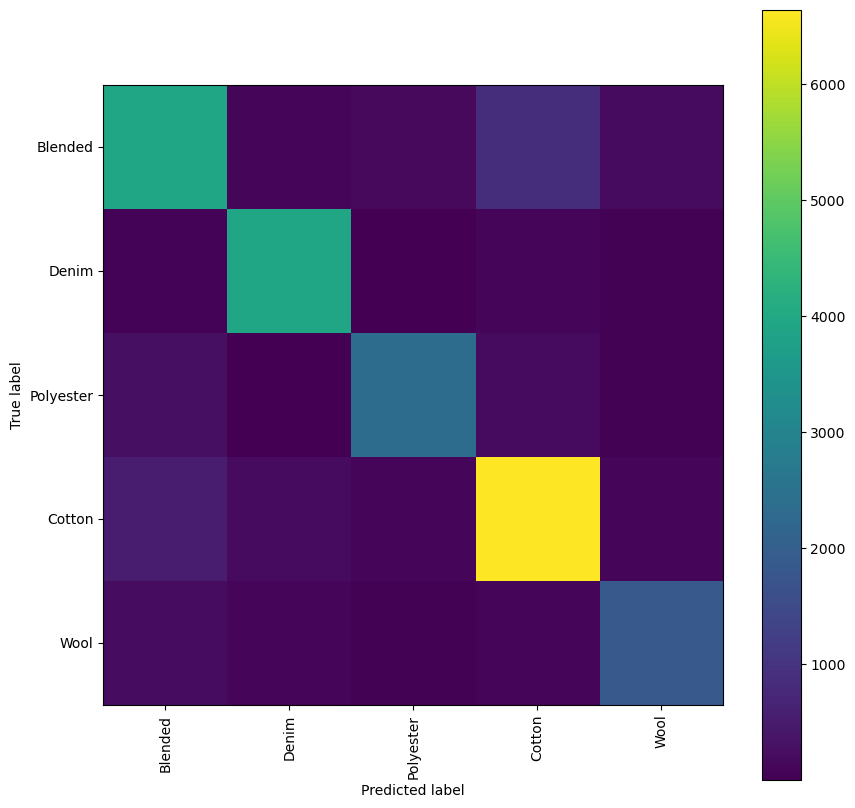

In [15]:
# Assuming X_test and y_test are available from the function; otherwise, split your dataset similarly outside the function
y_pred = cv_params.best_estimator_.predict(X)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

class_names = ['Blended', 'Denim', 'Polyester', 'Cotton', 'Wool']

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as necessary
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# To improve readability, you might not want to display labels for all classes if there are many of them
disp.plot(include_values=False, cmap='viridis', ax=ax, xticks_rotation='vertical')
# disp.plot(cmap='viridis', ax=ax, xticks_rotation='vertical')

plt.show()


In [14]:
train_df.head(20)

,label,category,0,1,2,3,4,5,6,7,...,22,23,24,25,26,27,28,29,30,31
0,0,Blended,3441.793288,2.028531e+07,1844.056770,0.150226,346.120911,0.005210,0.000093,0.000063,...,0.027344,0.054688,0.035156,0.039062,0.031250,0.027344,0.046875,0.062500,0.050781,0.050781
1,1,Denim,7211.992783,7.747671e+06,2271.840993,0.151475,348.998260,0.004833,-0.000067,0.000038,...,0.100000,0.048649,0.021622,0.024324,0.013514,0.021622,0.024324,0.043243,0.016216,0.070270
2,2,Polyester,8856.756862,5.854463e+06,1967.259618,0.160454,369.684998,0.002032,-0.000002,0.000008,...,0.027778,0.004630,0.004630,0.250000,0.129630,0.194444,0.018519,0.004630,0.027778,0.004630
3,0,Blended,7018.112788,7.817569e+06,1953.124972,0.152300,350.899200,0.004582,0.000011,0.000034,...,0.052239,0.063433,0.052239,0.007463,0.022388,0.044776,0.085821,0.074627,0.033582,0.029851
4,3,Cotton,7932.263905,6.971318e+06,2053.412469,0.157971,363.965454,0.002823,-0.000003,0.000017,...,0.030612,0.047619,0.054422,0.047619,0.051020,0.081633,0.013605,0.044218,0.047619,0.054422
5,3,Cotton,8092.511117,6.270290e+06,1967.068311,0.154521,356.016663,0.003901,-0.000080,0.000027,...,0.024169,0.000000,0.042296,0.117825,0.072508,0.093656,0.012085,0.012085,0.063444,0.024169
6,3,Cotton,7690.915562,6.869449e+06,1664.191839,0.151452,348.945190,0.004840,0.000079,0.000041,...,0.098592,0.056338,0.046948,0.051643,0.032864,0.051643,0.004695,0.004695,0.018779,0.056338
7,0,Blended,9567.840026,8.102730e+06,2446.820021,0.151374,348.766388,0.004864,-0.000052,0.000037,...,0.053678,0.071571,0.031809,0.041750,0.023857,0.023857,0.029821,0.043738,0.033797,0.133201
8,0,Blended,8320.616150,6.597614e+06,2115.668261,0.159309,367.048218,0.002398,-0.000026,0.000011,...,0.029197,0.000000,0.029197,0.124088,0.065693,0.058394,0.051095,0.007299,0.051095,0.007299
9,1,Denim,5816.332851,8.651580e+06,1777.162287,0.152271,350.831421,0.004591,0.000014,0.000036,...,0.049834,0.056478,0.046512,0.063123,0.026578,0.013289,0.036545,0.056478,0.036545,0.102990
